**Import libraries**

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.cubehelix_palette(10, start=2, rot=0, dark=0.2, light=0.8, reverse=True)
%matplotlib inline

# Training models#

## Read data##

In [5]:
aisles = pd.read_csv('aisles.csv')
depts = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
op_prior = pd.read_csv('order_products__prior.csv')
op_train = pd.read_csv('order_products__train.csv')

## Data cleaning##

There is no NAN value in any table except the column orders['days_since_prior_order']  
And the NAN value in orders['days_since_prior_order'] means the order is the first order for that user so it doesn't have prior order.  
So there is no need for us to remove any row with NAN value.

In [6]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Also, products['product_name'], aisles['aisle'], departments['department'] has string data.  
In case there are any mis-spellings, I lowercase all the strings and remove the space at the end of the string

In [7]:
products['product_name']=products['product_name'].str.lower().str.strip() 
aisles['aisle']=aisles['aisle'].str.lower().str.strip() 
depts['department']=depts['department'].str.lower().str.strip()

In [8]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,chocolate sandwich cookies,61,19
1,2,all-seasons salt,104,13
2,3,robust golden unsweetened oolong tea,94,7
3,4,smart ones classic favorites mini rigatoni wit...,38,1
4,5,green chile anytime sauce,5,13


In [9]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
depts.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## Merge different tables##

In [11]:
combined_data = pd.concat([op_prior, op_train])
combined_data = combined_data.merge(products, how="left", on="product_id")
combined_data = combined_data.merge(aisles, how="left", on="aisle_id")
combined_data = combined_data.merge(depts, how="left",  on="department_id")
combined_data = combined_data.merge(orders, how="left", on="order_id");
combined_data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,organic egg whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,michigan organic kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,garlic powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,coconut butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,natural sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


## Naive idea: calculate top 10 products according to the times of purchase##

In [19]:
def get_value_count_and_plot(data, title, limit=10):
    value_count = data.product_id.value_counts()[:limit]
    prod_ids = value_count.index.values
    prod_names = products[products.product_id.isin(prod_ids)].product_name
    prod_names = [name[:25]+'...' if len(name)>25 else "{0:<28}".format(name) for name in prod_names] # truncate names for presentation

    sns.set(font_scale=2)
    sns.barplot(y=prod_names, x=value_count.values, orient='h', palette=color)
    plt.suptitle(title)
    plt.show()

**Top products in overall**

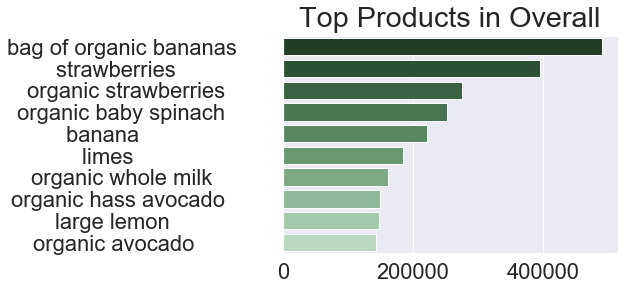

In [21]:
title =" Top Products in Overall"
get_value_count_and_plot(combined_data, title)

**Top products in different departments**

-----------------------


D:\Software_2\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


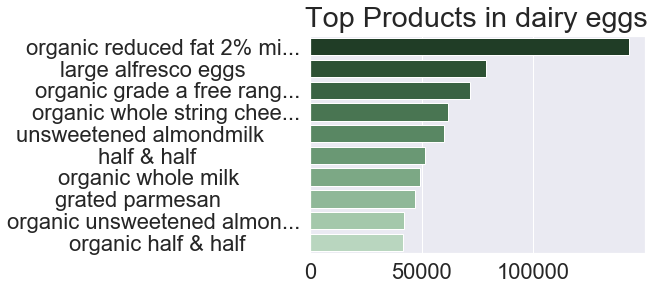

-----------------------


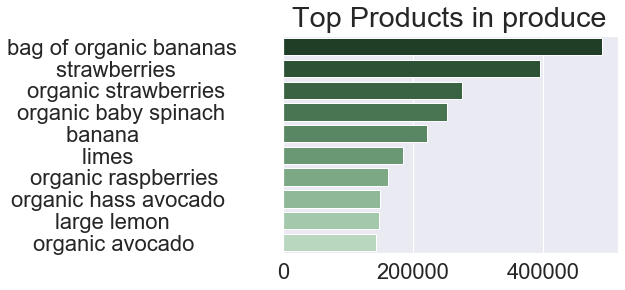

-----------------------


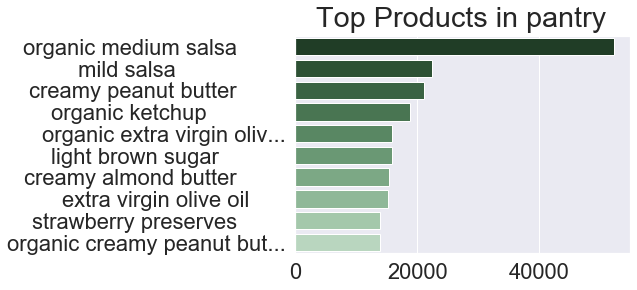

-----------------------


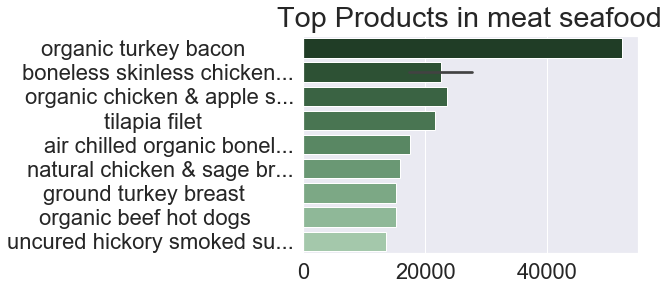

-----------------------


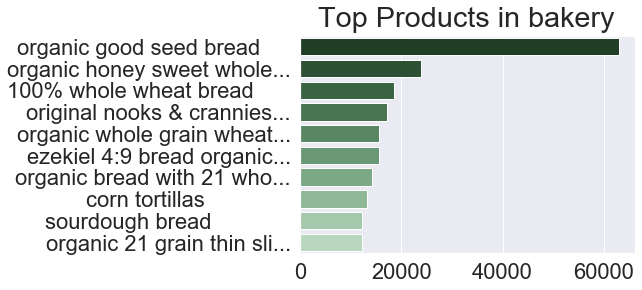

-----------------------


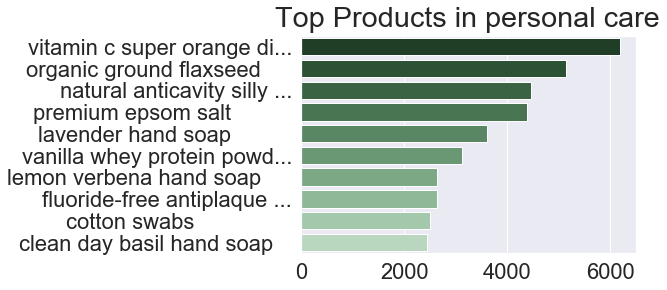

-----------------------


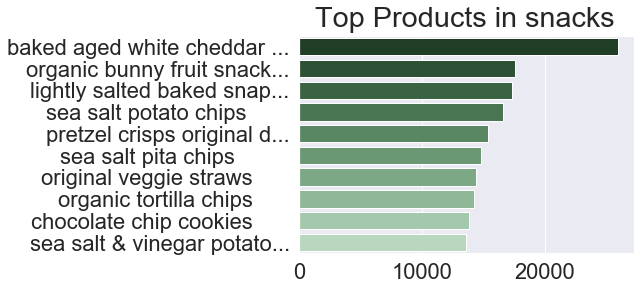

-----------------------


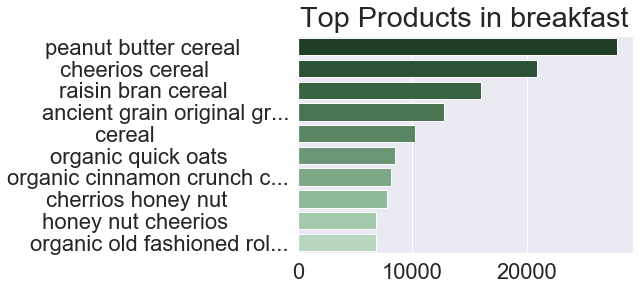

-----------------------


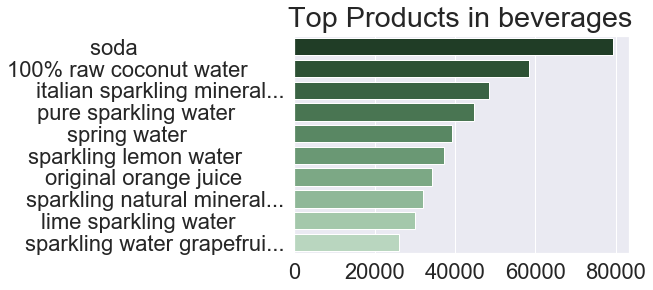

-----------------------


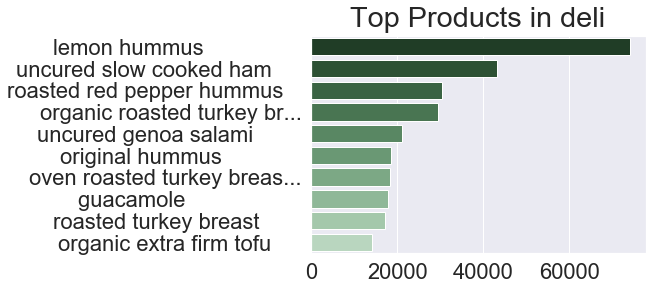

-----------------------


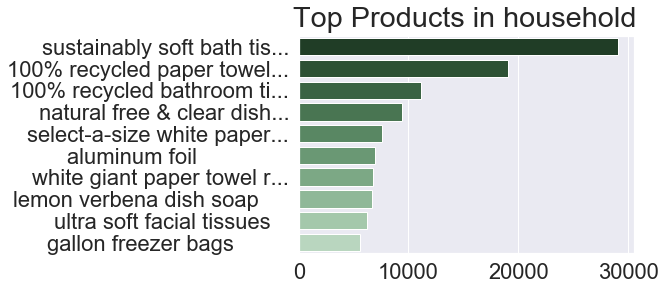

-----------------------


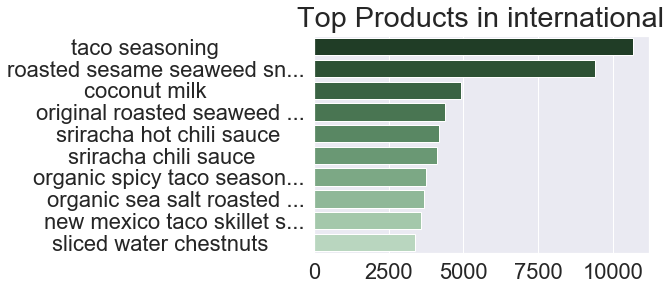

-----------------------


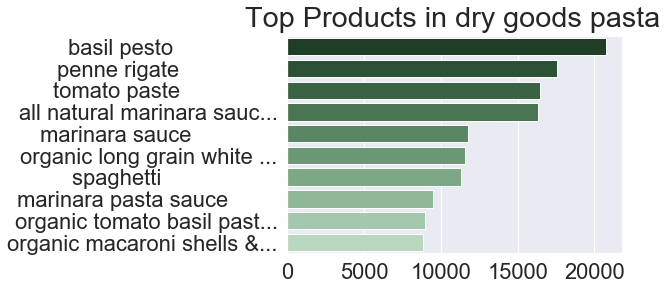

-----------------------


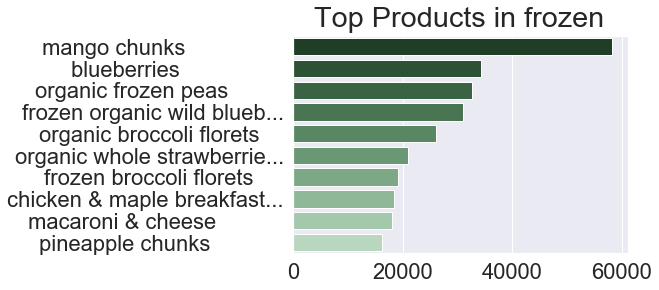

-----------------------


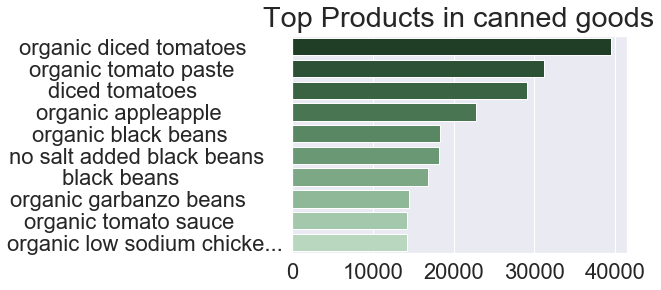

-----------------------


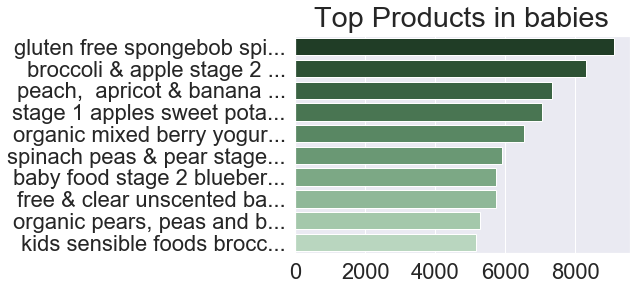

-----------------------


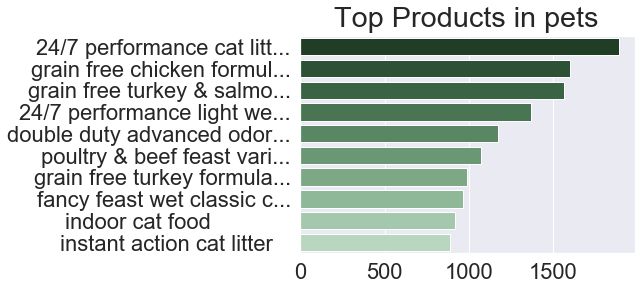

-----------------------


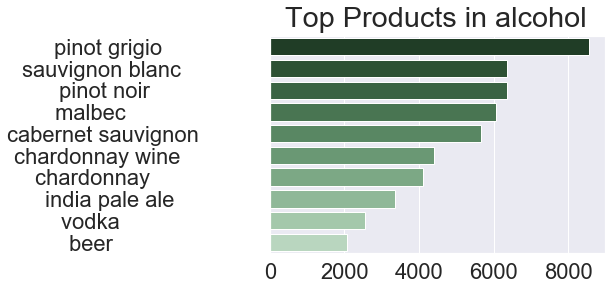

-----------------------


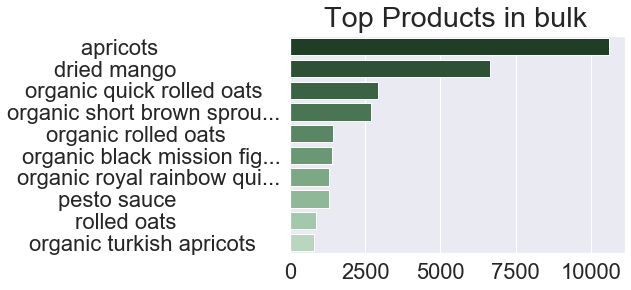

-----------------------


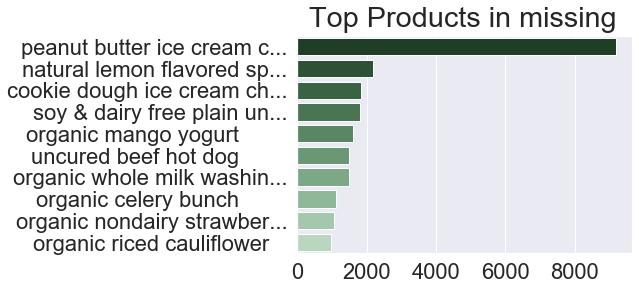

-----------------------


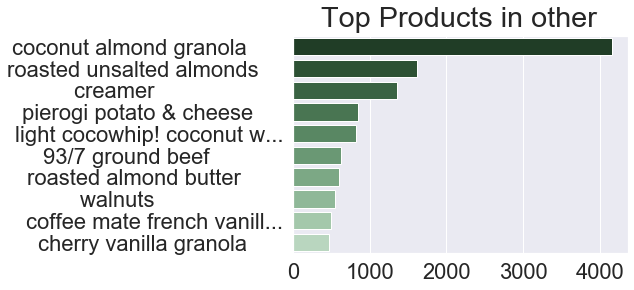

In [22]:
for d in combined_data.department_id.unique():
    print("-"*23)
    title =" Top Products in {}".format(depts.ix[d-1].department)
    data = combined_data[combined_data.department_id==d]
    get_value_count_and_plot(data, title)